In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from optuna.logging import get_logger
import matplotlib.pyplot as plt
import seaborn as sns

random_state = 6
np.random.seed(random_state)

In [4]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_validate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

columns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = columns
df_val.columns = columns
df_test.columns = columns

frames = [df_train, df_val]
df_train = pd.concat(frames)
print('train data shape {} and test data shape {}'.format(np.shape(df_train), np.shape(df_test)))

train data shape (1600, 9) and test data shape (400, 9)


In [5]:
def create_new_features(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    # Create new features
    df_new['height_width_ratio'] = df_new['height'] / df_new['width']
    df_new['normal_stress_diff'] = df_new['sxx'] - df_new['syy']
    df_new['friction_product'] = df_new['mud'] * (df_new['sdrop'])
    df_new['stress_ratio'] = df_new['sxy'] / df_new['syy']
    df_new['static_dynamic_friction_diff'] = (
        df_new['mud'] + df_new['sdrop']) - df_new['mud']
    df_new['stress_diff_dynamic_strength'] = df_new['sxy'] - \
        (df_new['syy'] * df_new['mud'])
    df_new['normalized_dc'] = df_new['dc'] / df_new['width']
    return df_new

In [6]:
df_train.describe()

,height,width,sxx,sxy,syy,sdrop,mud,dc,label
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.071973,1.493580,-86.124023,35.877919,-85.767890,0.393578,0.304785,0.401590,0.349375
std,0.045919,0.290491,44.589736,20.287076,41.857360,0.113716,0.087628,0.050475,0.476922
min,0.000003,1.000214,-198.643591,2.388038,-159.945235,0.200579,0.200045,0.233045,0.000000
25%,0.031667,1.242157,-120.350589,20.244549,-120.237232,0.295451,0.231681,0.367681,0.000000
50%,0.069885,1.481288,-82.773471,33.291381,-85.670660,0.389461,0.283825,0.401143,0.000000
75%,0.105252,1.743961,-50.453823,49.316321,-50.868223,0.486345,0.356399,0.434763,1.000000
max,0.195712,2.128935,-7.933036,97.618207,-10.011991,0.599913,0.573047,0.583352,1.000000


In [13]:
df_train.head()

,height,width,sxx,sxy,syy,sdrop,mud,dc,label
0,0.103861,1.145663,-102.509086,58.619371,-117.766562,0.483821,0.216681,0.295842,0.0
1,0.088714,1.304360,-136.062270,51.391037,-126.715571,0.345944,0.447964,0.406466,1.0
2,0.099706,1.260377,-117.558936,40.972081,-115.529343,0.292719,0.501697,0.389360,1.0
3,0.115749,1.191782,-128.169036,94.020712,-157.830504,0.571710,0.202831,0.408976,0.0
4,0.017900,1.108150,-106.350320,29.148969,-101.379323,0.253122,0.324653,0.398592,1.0


In [5]:
X_train = df_train.drop('label', axis=1)
X_train = create_new_features(X_train)
y_train = df_train['label'].values

# Validation data
X_val = df_val.drop('label', axis=1)
X_val = create_new_features(X_val)
y_val = df_val['label'].values

# Test data
X_test = df_test.drop('label', axis=1)
X_test = create_new_features(X_test)
y_test = df_test['label'].values

In [6]:
X_train.head(5)

,height,width,sxx,sxy,syy,sdrop,mud,dc,height_width_ratio,normal_stress_diff,friction_product,stress_ratio,static_dynamic_friction_diff,stress_diff_dynamic_strength,normalized_dc
0,0.103861,1.145663,-102.509086,58.619371,-117.766562,0.483821,0.216681,0.295842,0.090656,15.257476,0.104835,-0.497759,0.483821,84.137147,0.258228
1,0.088714,1.304360,-136.062270,51.391037,-126.715571,0.345944,0.447964,0.406466,0.068013,-9.346699,0.154970,-0.405562,0.345944,108.155051,0.311621
2,0.099706,1.260377,-117.558936,40.972081,-115.529343,0.292719,0.501697,0.389360,0.079108,-2.029593,0.146856,-0.354647,0.292719,98.932806,0.308923
3,0.115749,1.191782,-128.169036,94.020712,-157.830504,0.571710,0.202831,0.408976,0.097123,29.661468,0.115961,-0.595707,0.571710,126.033631,0.343163
4,0.017900,1.108150,-106.350320,29.148969,-101.379323,0.253122,0.324653,0.398592,0.016153,-4.970997,0.082177,-0.287524,0.253122,62.062070,0.359691


In [7]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 4, 50.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                      early_stopping_rounds=100, verbose_eval=False)

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = np.round(y_pred).astype(int)

    y_val_pred = model.predict(X_val)
    y_val_pred = np.round(y_val_pred).astype(int)
    score = f1_score(y_val, y_val_pred, average='macro')
    
    return score


In [ ]:
# Define a silent callback
def silent_callback(study, trial):
    if study.trials[-1].state == optuna.trial.TrialState.COMPLETE:
        logger.info("Trial {} finished with value: {} and parameters: {}".format(
            trial.number, trial.value, trial.params))

logger = get_logger("optuna")
logger.setLevel("INFO")

study = optuna.create_study(
    direction='maximize')

# Run optimization
study.optimize(
    objective,
    n_trials=30,
    show_progress_bar=True,
    callbacks=[silent_callback]
)

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Best score: {trial.value}')
print(f'Best Params: {trial.params}')

In [ ]:
# Train model with the best parameters
best_params = trial.params
lgb_train = lgb.Dataset(X_train, y_train)

In [ ]:
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

best_supervised_model = lgb.train(best_params, lgb_train, valid_sets=lgb_test,
                       early_stopping_rounds=100, verbose_eval=False)


In [ ]:
y_pred = best_supervised_model.predict(X_test, num_iteration=best_supervised_model.best_iteration)
test_score = roc_auc_score(y_test, y_pred)
print(f'Test Roc-AUC score: {test_score}')

In [ ]:
### Classification report
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))

In [ ]:
### Save the model
best_supervised_model.save_model('./models/best_supervised_model.txt')

In [ ]:
### Load the model
# best_supervised_model = lgb.Booster(model_file='./models/best_supervised_model.txt')

### Visualization of hyperparameter importance using Optuna

In [ ]:
import optuna.visualization as vis

In [ ]:
# Plot optimization history
plot_optimization_history = vis.plot_optimization_history(study)
plot_optimization_history.show()

In [ ]:
# Plot parameter importances
plot_param_importances = vis.plot_param_importances(study)
plot_param_importances.show()

In [ ]:
# Plot parallel coordinate plot
plot_parallel_coordinate = vis.plot_parallel_coordinate(study)
plot_parallel_coordinate.show()

In [ ]:
# Plot slice plot
plot_slice = vis.plot_slice(study)
plot_slice.show()

In [ ]:
# Plot contour plot
# Best Params: {'scale_pos_weight': 8.849103938047977, 'learning_rate': 0.11651683871291287, 'n_estimators': 710, 'boosting_type': 'dart', 'lambda_l1': 1.0263206593735317e-05, 'lambda_l2': 3.729990954390867e-08, 'num_leaves': 48, 'feature_fraction': 0.49816303001038625, 'bagging_fraction': 0.7791692888330242, 'bagging_freq': 4, 'min_child_samples': 30}

plot_contour = vis.plot_contour(study, params=['num_leaves', 'n_estimators'])
plot_contour.show()


### Data Preparation for Unsupervised Learning

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [33]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)


cuda


### Normalize the data

In [34]:
# Normalize input data (excluding the 'label' column)
train_columns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc']
scaler = MinMaxScaler().fit(X_train[train_columns].values)

# Create a PyTorch train dataset and dataloader
normalized_data = scaler.transform(X_train[train_columns].values)
X_tensor = torch.tensor(normalized_data, dtype=torch.float32)
Y_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create validation dataset and dataloader
normalized_data = scaler.transform(X_val[train_columns].values)
X_tensor = torch.tensor(normalized_data, dtype=torch.float32)
Y_tensor = torch.tensor(y_val, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
val_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
 
 
 # Create test dataset and dataloader
normalized_data = scaler.transform(X_test[train_columns].values)
X_tensor = torch.tensor(normalized_data, dtype=torch.float32)
Y_tensor = torch.tensor(y_test, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [35]:
test_dataloader.dataset.tensors[1].shape

torch.Size([400])

### Generator and Discriminator models

In [81]:
import torch
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



In [82]:
# Example usage
generator_input_dim = 100
generator_output_dim = 8

discriminator_input_dim = 8
discriminator_output_dim = 1

generator = Generator(generator_input_dim,
                      generator_hidden_dim, generator_output_dim).to(device)

discriminator = Discriminator(
    discriminator_input_dim, discriminator_hidden_dim, discriminator_output_dim).to(device)

In [83]:
import torch.optim as optim

# Hyperparameters
epochs = 1000
batch_size = 16
lr = 0.0002

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Lists for recording losses
discriminator_losses = []
generator_losses = []

for epoch in range(epochs):

    for real_data, _ in train_dataloader:
        batch_size = real_data.size(0)

        # Train the discriminator
        optimizer_D.zero_grad()

        # Train with real data
        real_label = torch.ones(batch_size, 1).to(device)
        real_output = discriminator(real_data.to(device))
        real_loss = criterion(real_output, real_label)

        # Train with fake data
        noise = torch.randn(batch_size, generator_input_dim).to(device)
        fake_data = generator(noise)
        fake_label = torch.zeros(batch_size, 1).to(device)
        fake_output = discriminator(fake_data.detach())
        fake_loss = criterion(fake_output, fake_label)

        # Update the discriminator
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()

        # Generate fake data
        noise = torch.randn(batch_size, generator_input_dim).to(device)
        fake_data = generator(noise)

        # Train the generator to fool the discriminator
        output = discriminator(fake_data)
        generator_loss = criterion(output, real_label)
        generator_loss.backward()
        optimizer_G.step()

        # Record losses
        discriminator_losses.append(discriminator_loss.item())
        generator_losses.append(generator_loss.item())
        
    # Save best models
    if epoch == 0:
        best_generator_loss = generator_loss.item()
        best_discriminator_loss = discriminator_loss.item()
        torch.save(generator.state_dict(), './models/best_generator.pt')
        torch.save(discriminator.state_dict(), './models/best_discriminator.pt')
    else:
        if generator_loss.item() < best_generator_loss:
            best_generator_loss = generator_loss.item()
            torch.save(generator.state_dict(), './models/best_generator.pt')
        if discriminator_loss.item() < best_discriminator_loss:
            best_discriminator_loss = discriminator_loss.item()
            torch.save(discriminator.state_dict(), './models/best_discriminator.pt')
             
    # Print losses
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}] Discriminator Loss: {discriminator_loss.item()}, Generator Loss: {generator_loss.item()}")

Epoch [100/1000] Discriminator Loss: 1.369302749633789, Generator Loss: 0.7147249579429626
Epoch [200/1000] Discriminator Loss: 1.4454288482666016, Generator Loss: 0.6954079270362854
Epoch [300/1000] Discriminator Loss: 1.3604177236557007, Generator Loss: 0.5970274806022644
Epoch [400/1000] Discriminator Loss: 1.3372066020965576, Generator Loss: 0.6580452919006348
Epoch [500/1000] Discriminator Loss: 1.3738499879837036, Generator Loss: 0.7773289680480957
Epoch [600/1000] Discriminator Loss: 1.3833675384521484, Generator Loss: 0.698786735534668
Epoch [700/1000] Discriminator Loss: 1.3894259929656982, Generator Loss: 0.6775549054145813
Epoch [800/1000] Discriminator Loss: 1.3800835609436035, Generator Loss: 0.6759234070777893
Epoch [900/1000] Discriminator Loss: 1.3558225631713867, Generator Loss: 0.6651424765586853
Epoch [1000/1000] Discriminator Loss: 1.37459135055542, Generator Loss: 0.6587144136428833


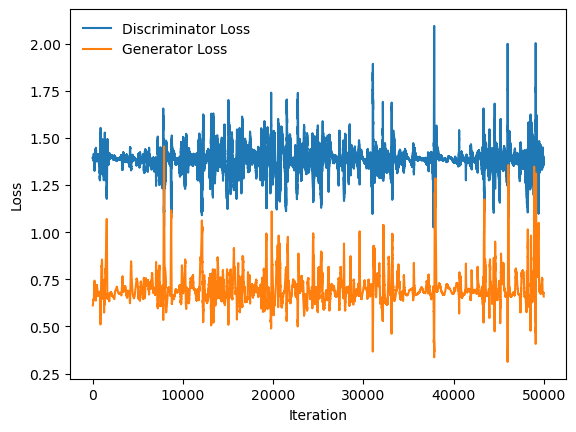

In [84]:
# Plot losses
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.plot(generator_losses, label="Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()


In [61]:
# Create a random input for the generator
random_input = torch.randn(2, generator_input_dim)

# Generate data using the generator
generated_data = generator(random_input.to(device))

# Pass the generated data through the discriminator
discriminator_output = discriminator(generated_data)

In [62]:
generated_data

tensor([[1., 0., 1., 1., 0., 0., 0., 1.],
        [1., 0., 1., 1., 0., 0., 0., 1.]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [63]:
discriminator_output

tensor([[4.1142e-12],
        [4.1142e-12]], device='cuda:0', grad_fn=<SigmoidBackward0>)

### Variational Autoencoder

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers):
        super(VAE, self).__init__()

        assert len(hidden_dim) == num_layers, "hidden_dim and num_layers must be the same length"
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        self.encoder = self.create_encoder()
        self.fc_mu = nn.Linear(self.hidden_dim[-1], self.latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_dim[-1], self.latent_dim)
        self.decoder = self.create_decoder()

    def create_encoder(self):
        # Encoder
        encoder = nn.Sequential()
        encoder.add_module(
            "linear_0", nn.Linear(self.input_dim, self.hidden_dim[0]))
        encoder.add_module("relu_0", nn.ReLU())

        for layer in range(1, self.num_layers):
            encoder.add_module(
                f"linear_{layer}", nn.Linear(self.hidden_dim[layer-1], self.hidden_dim[layer]))
            encoder.add_module(f"relu_{layer}", nn.ReLU())
        return encoder
        
    def create_decoder(self):
        # Decoder
        decoder = nn.Sequential()
        decoder.add_module(
            "linear_0", nn.Linear(self.latent_dim, self.hidden_dim[0]))
        decoder.add_module("relu_0", nn.ReLU())

        for layer in range(1, self.num_layers):
            decoder.add_module(
                f"linear_{layer}", nn.Linear(self.hidden_dim[layer-1], self.hidden_dim[layer]))
            decoder.add_module(f"relu_{layer}", nn.ReLU())
        decoder.add_module(
            "linear_output", nn.Linear(self.hidden_dim[-1], self.input_dim))
        decoder.add_module("sigmoid_output", nn.Sigmoid())
        return decoder
        

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        output = self.decoder(z)
        return output, mu, logvar


In [ ]:
def objective(trial):
    # 1. Suggest values for hyper-parameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 2, 3)
    latent_dim = trial.suggest_int("latent_dim", 16, 64)
    hidden_dims = [trial.suggest_int(
        f"hidden_dim_{i}", 16, 128) for i in range(num_layers)]
    input_dim = X_tensor.shape[1]

    # 2. Create the model, optimizer, and loss function
    model = VAE(input_dim, hidden_dims, latent_dim, num_layers)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    recon_loss_fn = nn.MSELoss(reduction='sum')

    # 3. Train the model
    best_loss = np.inf
    n_epochs = 500  # number of epochs
    for epoch in range(n_epochs):
        for batch in train_dataloader:
            optimizer.zero_grad()
            x = Variable(batch[0])
            recon_x, mu, logvar = model(x)
            recon_loss = recon_loss_fn(recon_x, x)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss
            loss.backward()
            optimizer.step()

    # 4. Evaluate the model
    model.eval()
    total_recon_loss = 0
    total_kl_loss = 0
    total_validation_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            x = Variable(batch[0])
            recon_x, mu, logvar = model(x)
            recon_loss = recon_loss_fn(recon_x, x)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + 0.5*kl_loss
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_validation_loss += loss.item()

    mean_kl_loss = total_kl_loss / len(val_dataloader)
    mean_recon_loss = total_recon_loss / len(val_dataloader)
    mean_validation_loss = total_validation_loss / len(val_dataloader)
    
    # Save best model
    if mean_validation_loss < best_loss:
        best_loss = mean_validation_loss
        torch.save(model.state_dict(), "./models/vae_best_model.pt")
    print(
        f"Validation Loss: {mean_validation_loss}, Recon loss: {mean_recon_loss}, KL loss: {mean_kl_loss}")
    return mean_validation_loss

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
print(f"Best trial: {best_trial.number}")
print(f"Best value: {best_trial.value}")
print("Best parameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

### Generate data

In [ ]:
num_samples = 5  # number of samples you want to generate
latent_dim = 32  # dimension of the latent space
z = torch.randn(num_samples, latent_dim)
model.eval()
with torch.no_grad():
    generated_data = model.decoder(z).cpu().numpy()

In [ ]:
generated_data

In [ ]:
inv_gen_train = scaler.inverse_transform(generated_data)

In [ ]:
inv_gen_train

In [ ]:
gen_train = pd.DataFrame(inv_gen_train, columns=train_columns)


In [ ]:
gen_train


In [ ]:
best_supervised_model.predict(scaler.inverse_transform(generated_data))

In [ ]:
best_trial = study.best_trial
best_vae_params = best_trial.params
print(best_vae_params)

In [ ]:
study.best_model

In [ ]:
best_model = VAE(input_dim, hidden_dim, latent_dim)


In [ ]:
num_samples = 1000  # number of samples you want to generate
latent_dim = best_vae_params["latent_dim"]  # dimension of the latent space
z = torch.randn(num_samples, latent_dim)
print(z.shape)
print(z[100])

In [ ]:
vae = VAE(input_dim, hidden_dim, latent_dim)

In [ ]:
with torch.no_grad():
    generated_data = vae.decoder(z).cpu().numpy()